In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import os
import pandas as pd
import numpy as np
import cv2

In [5]:
annotation_path = '/mnt/d/CharadesEgo/Annotations'
# print all files in the annotation path
print(os.listdir(annotation_path))
# train_csv
train_csv = pd.read_csv('/mnt/d/CharadesEgo/Annotations/CharadesEgo_v1_train_only1st.csv')
test_csv = pd.read_csv('/mnt/d/CharadesEgo/Annotations/CharadesEgo_v1_test_only1st.csv')
VIDEO_PATH = '/mnt/d/CharadesEgo/CharadesEgo_v1_480'
CLASS_MAP = '/mnt/d/CharadesEgo/Annotations/Charades_v1_classes.txt'
# # print train_csv
# print(train_csv.head())
# # print test_csv
# print(test_csv.head())

# make sure the full content of each cell is visible
pd.set_option('display.max_colwidth', None)

['CharadesEgo_v1_test.csv', 'CharadesEgo_v1_test_only1st.csv', 'CharadesEgo_v1_test_only3rd.csv', 'CharadesEgo_v1_train.csv', 'CharadesEgo_v1_train_only1st.csv', 'CharadesEgo_v1_train_only3rd.csv', 'Charades_v1_classes.txt', 'Charades_v1_classify.m', 'Charades_v1_localize.m', 'Charades_v1_mapping.txt', 'Charades_v1_objectclasses.txt', 'Charades_v1_verbclasses.txt', 'license.txt', 'README.txt']


In [6]:
# read CLASS_MAP into a dictionary mapping class IDs to descriptions
class_map = {}
with open(CLASS_MAP, 'r') as f:
    for line in f:
        class_id, description = line.strip().split(' ', 1)
        class_map[class_id] = description
print("First 10 classes:")
for i, (class_id, desc) in enumerate(class_map.items()):
    if i >= 10:
        break
    print(f"{class_id}: {desc}")

First 10 classes:
c000: Holding some clothes
c001: Putting clothes somewhere
c002: Taking some clothes from somewhere
c003: Throwing clothes somewhere
c004: Tidying some clothes
c005: Washing some clothes
c006: Closing a door
c007: Fixing a door
c008: Opening a door
c009: Putting something on a table


In [7]:
def parse_action_segments(action_segments):
    segments = []
    for segment in action_segments:
        # split segment by space
        segment = segment.split(' ')
        # convert to tuple of str, float, float
        segments.append((segment[0], float(segment[1]), float(segment[2])))
    return segments

# apply parse_action_segments to actions_list column

In [8]:
# compare the number of rows before and after
print(len(train_csv))

# from train_csv, keep only rows where actions is str
train_csv = train_csv[train_csv['actions'].apply(type) == str]
# print the number of rows after filtering
print(len(train_csv))

# convert actions column to list
train_csv['actions_list'] = train_csv['actions'].apply(lambda x: x.split(';'))

# apply parse_action_segments to actions_list column
train_csv['actions_list'] = train_csv['actions_list'].apply(parse_action_segments)
print(train_csv['actions_list'].head())


3084
3078
0                    [(c156, 3.9, 12.0), (c061, 8.2, 12.5), (c106, 9.9, 18.4), (c067, 12.8, 17.9), (c008, 12.2, 18.7), (c065, 11.2, 18.1), (c104, 11.7, 17.6), (c006, 12.5, 17.9), (c156, 3.9, 31.25), (c107, 1.0, 31.25), (c061, 1.3, 29.7), (c106, 10.9, 31.25)]
1    [(c109, 19.9, 24.29), (c107, 16.8, 23.8), (c106, 10.1, 21.0), (c077, 0.0, 3.8), (c126, 0.0, 3.6), (c110, 5.4, 10.1), (c154, 0.0, 18.3), (c061, 18.8, 24.29), (c079, 6.2, 10.8), (c110, 7.6, 24.29), (c080, 5.0, 10.4), (c076, 5.1, 10.8), (c092, 8.0, 24.29)]
2                                                                           [(c107, 16.5, 22.04), (c110, 15.3, 21.0), (c109, 23.1, 22.04), (c017, 13.5, 21.4), (c015, 0.0, 16.6), (c153, 10.2, 16.3), (c059, 0.0, 22.04), (c106, 17.3, 22.04), (c011, 0.0, 22.04)]
3                                                                                                       [(c073, 14.9, 20.0), (c095, 0.0, 15.9), (c070, 10.2, 20.0), (c000, 0.0, 20.0), (c002, 0.1, 20.0), (c035, 0.0,

In [9]:
# merge all action_list values into a single list with corresponding video IDs
all_action_segments = [(segment, id) for id, action_list in zip(train_csv['id'], train_csv['actions_list']) for segment in action_list]
print(len(all_action_segments))

# convert all_action_segments to a pandas DataFrame
action_segments_df = pd.DataFrame([(action, start, end, video_id) for (action, start, end), video_id in all_action_segments], 
                                columns=['action', 'start', 'end', 'video_id'])

# add a column for the video length (start to end)
action_segments_df['action_duration'] = action_segments_df['end'] - action_segments_df['start']
print(action_segments_df.head())

34256
  action  start   end  video_id  action_duration
0   c156    3.9  12.0  D3TR8EGO              8.1
1   c061    8.2  12.5  D3TR8EGO              4.3
2   c106    9.9  18.4  D3TR8EGO              8.5
3   c067   12.8  17.9  D3TR8EGO              5.1
4   c008   12.2  18.7  D3TR8EGO              6.5


In [10]:
test_csv = pd.read_csv('/mnt/d/CharadesEgo/Annotations/CharadesEgo_v1_test_only1st.csv')

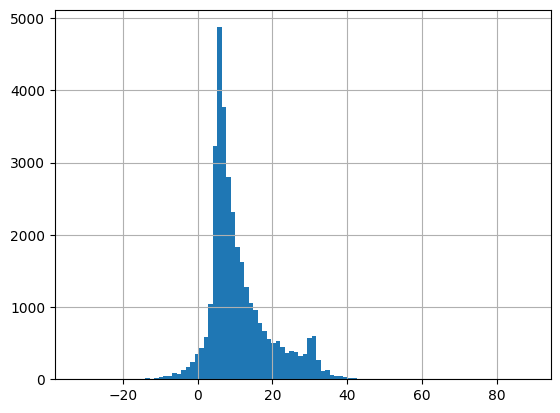

Mean action duration: 11.09 seconds
Standard deviation: 8.47 seconds

Shapiro-Wilk test results:
Statistic: 0.8938
p-value: 0.0000e+00

Null hypothesis: Distribution is normal
The distribution is not normal (α=0.05)


/home/jinseo/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [11]:
import matplotlib.pyplot as plt
# get a histogram of action_duration
action_segments_df['action_duration'].hist(bins=100)
plt.show()

# Perform Shapiro-Wilk test for normality
from scipy import stats

# Get descriptive statistics
mean_duration = action_segments_df['action_duration'].mean()
std_duration = action_segments_df['action_duration'].std()
print(f"Mean action duration: {mean_duration:.2f} seconds")
print(f"Standard deviation: {std_duration:.2f} seconds")

# Perform normality test
stat, p_value = stats.shapiro(action_segments_df['action_duration'])
print("\nShapiro-Wilk test results:")
print(f"Statistic: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print("\nNull hypothesis: Distribution is normal")
print(f"The distribution is {'normal' if p_value > 0.05 else 'not normal'} (α=0.05)")



In [12]:
list(class_map.keys())

['c000',
 'c001',
 'c002',
 'c003',
 'c004',
 'c005',
 'c006',
 'c007',
 'c008',
 'c009',
 'c010',
 'c011',
 'c012',
 'c013',
 'c014',
 'c015',
 'c016',
 'c017',
 'c018',
 'c019',
 'c020',
 'c021',
 'c022',
 'c023',
 'c024',
 'c025',
 'c026',
 'c027',
 'c028',
 'c029',
 'c030',
 'c031',
 'c032',
 'c033',
 'c034',
 'c035',
 'c036',
 'c037',
 'c038',
 'c039',
 'c040',
 'c041',
 'c042',
 'c043',
 'c044',
 'c045',
 'c046',
 'c047',
 'c048',
 'c049',
 'c050',
 'c051',
 'c052',
 'c053',
 'c054',
 'c055',
 'c056',
 'c057',
 'c058',
 'c059',
 'c060',
 'c061',
 'c062',
 'c063',
 'c064',
 'c065',
 'c066',
 'c067',
 'c068',
 'c069',
 'c070',
 'c071',
 'c072',
 'c073',
 'c074',
 'c075',
 'c076',
 'c077',
 'c078',
 'c079',
 'c080',
 'c081',
 'c082',
 'c083',
 'c084',
 'c085',
 'c086',
 'c087',
 'c088',
 'c089',
 'c090',
 'c091',
 'c092',
 'c093',
 'c094',
 'c095',
 'c096',
 'c097',
 'c098',
 'c099',
 'c100',
 'c101',
 'c102',
 'c103',
 'c104',
 'c105',
 'c106',
 'c107',
 'c108',
 'c109',
 'c110',
 

In [13]:
# First, create a mapping of action classes to integers
unique_actions = sorted(list(class_map.keys()))
action_to_idx = {action: idx for idx, action in enumerate(unique_actions)}
idx_to_action = {idx: action for action, idx in action_to_idx.items()}

print(f"Number of unique action classes: {len(unique_actions)}")
print("\nFirst few action mappings:")
for i in range(min(5, len(unique_actions))):
    print(f"{unique_actions[i]} -> {action_to_idx[unique_actions[i]]}")

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(action_segments_df, test_size=0.2, random_state=42, stratify=action_segments_df['action'])

print(f"Training set size: {len(train_df)}, Validation set size: {len(val_df)}")

# Create a custom dataset for video segments
class VideoSegmentDataset(torch.utils.data.Dataset):
    def __init__(self, segments_df, video_path, num_frames=16, frame_size=(160, 160), action_to_idx=None):
        self.segments_df = segments_df
        self.video_path = video_path
        self.num_frames = num_frames
        self.frame_size = frame_size
        self.action_to_idx = action_to_idx
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(frame_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def __len__(self):
        return len(self.segments_df)
    
    def __getitem__(self, idx):
        # Get video info
        video_id = self.segments_df.iloc[idx]['video_id']
        start_time = self.segments_df.iloc[idx]['start']
        end_time = self.segments_df.iloc[idx]['end']
        action_class = self.segments_df.iloc[idx]['action']
        
        # Convert action class to integer index
        if self.action_to_idx is not None:
            action_idx = self.action_to_idx[action_class]
        else:
            action_idx = action_class  # If no mapping provided, assume it's already an integer
        
        # Load video
        video_file = os.path.join(self.video_path, video_id + '.mp4')
        cap = cv2.VideoCapture(video_file)
        
        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Calculate start and end frames
        start_frame = int(start_time * fps)
        end_frame = min(int(end_time * fps), total_frames)
        
        # Sample frames evenly from the segment
        if end_frame - start_frame >= self.num_frames:
            # If we have more frames than needed, sample evenly
            frame_indices = np.linspace(start_frame, end_frame-1, self.num_frames, dtype=int)
        else:
            # If we have fewer frames, loop the video
            frame_indices = np.array([(start_frame + i) % (end_frame - start_frame) + start_frame 
                                     for i in range(self.num_frames)])
        
        # Extract frames
        frames = []
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret:
                # If frame reading fails, create a blank frame
                frame = np.zeros((self.frame_size[0], self.frame_size[1], 3), dtype=np.uint8)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(frame)
            frames.append(frame)
        
        cap.release()
        
        # Stack frames to create video tensor [C, T, H, W]
        video_tensor = torch.stack(frames, dim=1)  # Shape: [3, 32, 224, 224]
        
        return video_tensor, action_idx

# Use train_df for training dataset
train_dataset = VideoSegmentDataset(train_df, VIDEO_PATH, num_frames=8, frame_size=(80, 80), action_to_idx=action_to_idx)

# Use val_df for validation dataset with the same action_to_idx mapping
val_dataset = VideoSegmentDataset(val_df, VIDEO_PATH, num_frames=8, frame_size=(80, 80), action_to_idx=action_to_idx)

# Create dataloaders
batch_size = 4  # Reduced from 8
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,  # Reduced from 4
    pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2,  # Reduced from 4
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
print(f"Number of batches in train_loader: {len(train_loader)}")

# Verify that the labels are now integers
sample_batch = next(iter(train_loader))
videos, labels = sample_batch
print(f"\nSample batch labels shape: {labels.shape}")
print(f"Sample labels: {labels}")
print(f"Label types: {labels.dtype}")

Number of unique action classes: 157

First few action mappings:
c000 -> 0
c001 -> 1
c002 -> 2
c003 -> 3
c004 -> 4
Training set size: 27404, Validation set size: 6852
Training samples: 27404, Validation samples: 6852
Number of batches in train_loader: 6851

Sample batch labels shape: torch.Size([4])
Sample labels: tensor([ 33, 132,   4,  65])
Label types: torch.int64


In [14]:
# check pytorch version
print(torch.__version__)

# check cuda version
print(torch.cuda.is_available())

2.6.0+cu124
True


In [15]:
# construct a simple 3D CNN model for video classification
class VideoCNN(nn.Module):
    def __init__(self):
        super(VideoCNN, self).__init__()
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv3 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        # Calculate the correct input size for the first fully connected layer
        # For 16 frames of 160x160 input, after pooling operations
        self.fc1 = nn.Linear(51200, 1024)
        self.fc2 = nn.Linear(1024, 157)  # 157 classes (c000 to c156)
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)  # Add dropout
        x = self.fc1(x)
        x = self.dropout(x)  # Add dropout
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, val_loader, criterion, optimizer, num_epochs):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        self.to(device)
        
        for epoch in range(num_epochs):
            # Clear GPU cache at the start of each epoch
            torch.cuda.empty_cache()
            
            # Initialize metrics for each epoch
            running_loss = 0.0
            correct = 0
            total = 0
            
            for i, (inputs, labels) in enumerate(train_loader, 0):
                # Clear GPU cache periodically (every 10 batches)
                if i % 10 == 0:
                    torch.cuda.empty_cache()
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                print(f"Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

                # Clear memory after each batch
                del outputs, loss
                torch.cuda.empty_cache()
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100. * correct / total
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
            
            # validation
            self.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    outputs = self(inputs)  
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    
            val_loss = val_loss / len(val_loader)
            val_acc = 100. * correct / total
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
            
        print("Training complete")

In [2]:
# initialize model
model = VideoCNN()

# Define hyperparameters
num_epochs = 1
learning_rate = 0.001
batch_size = 6

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model.train_model(train_loader, val_loader, criterion, optimizer, num_epochs)

NameError: name 'VideoCNN' is not defined

In [16]:
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [21]:
# Add this code to check GPU memory usage
def print_gpu_memory():
    print(f"GPU Memory Usage:")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

